In [1]:
from alf_utils import undistort, lane_edges, lane_poly, radius_of_curvature, fill_lane
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Camera calibration

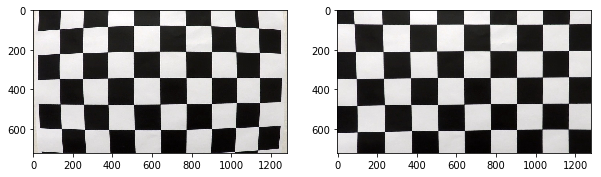

In [2]:
mtx, dist = undistort('camera_cal/')

img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(dst[:,:,::-1])

# Perspective Transform

In [3]:
pts = np.array([[191,720],
                [594,450],
                [688,450],
                [1120,720]], dtype="float32")
dst = np.array([[191,720],
                [191,0],
                [1120,0],
                [1120,720]], dtype="float32")

M = cv2.getPerspectiveTransform(pts, dst)
Minv = cv2.getPerspectiveTransform(dst, pts)

In [4]:
img = cv2.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
warped = cv2.warpPerspective(undist, M, (1280, 720))

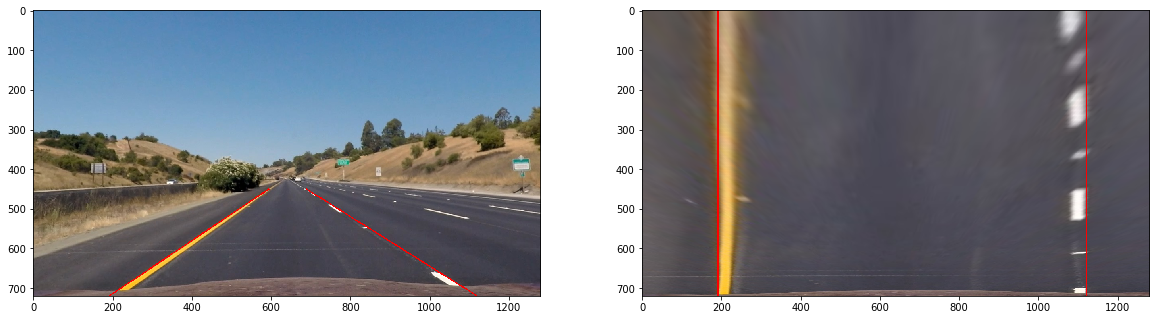

In [5]:
_ = cv2.line(undist,(191,720),(594,450),(0,0,255),2)
_ = cv2.line(undist,(688,450),(1120,720),(0,0,255),2)
_ = cv2.line(warped,(191,720),(191,0),(0,0,255),2)
_ = cv2.line(warped,(1120,0),(1120,720),(0,0,255),2)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(undist[:,:,::-1])
plt.subplot(122)
plt.imshow(warped[:,:,::-1])

# Lane Edges

In [6]:
img = cv2.imread('test_images/test2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
binary = lane_edges(undist)
binary_warped = cv2.warpPerspective(binary, M, (1280, 720))

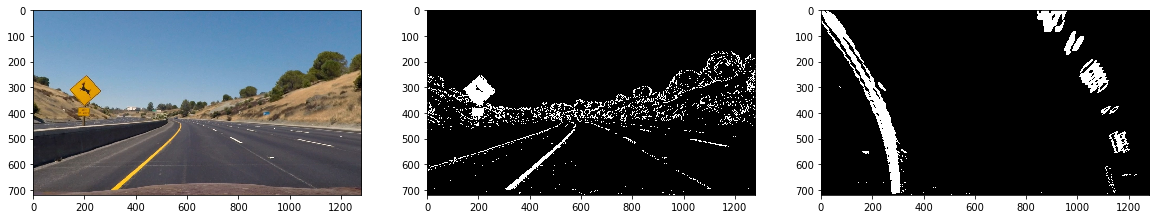

In [7]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(undist[:,:,::-1])
plt.subplot(132)
plt.imshow(binary, cmap='gray')
plt.subplot(133)
plt.imshow(binary_warped, cmap='gray')

# Polynomial Fit

In [8]:
left_fit, right_fit = lane_poly(binary_warped)

# Fill Lane

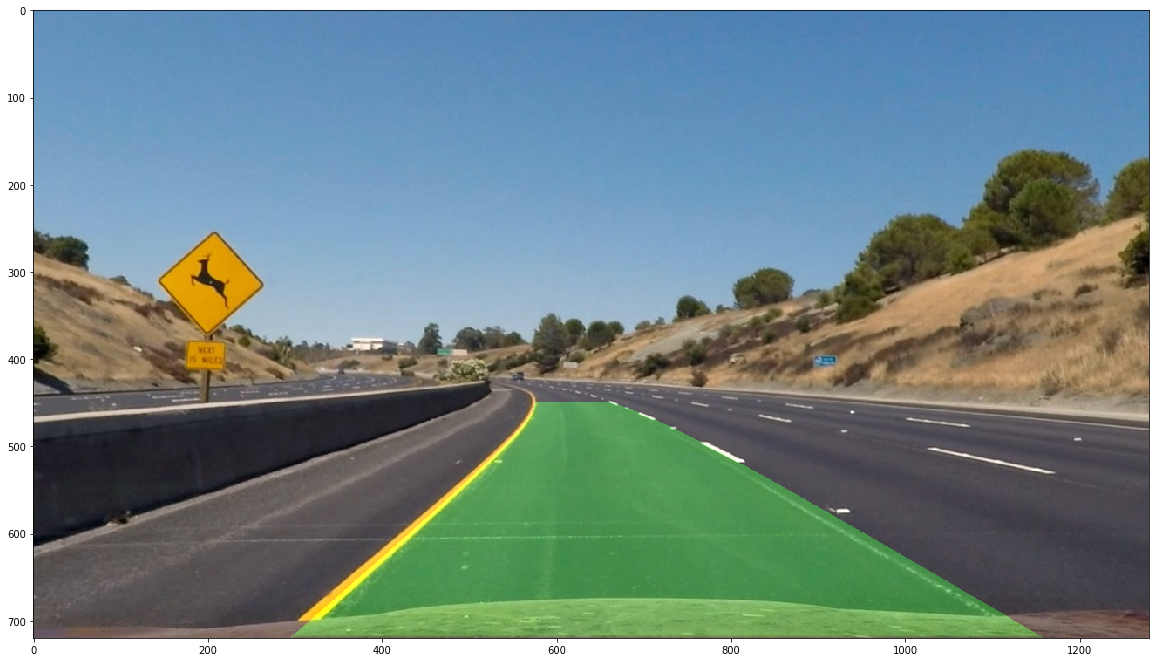

In [10]:
fill_img = fill_lane(undist, binary_warped, left_fit, right_fit, Minv)

plt.figure(figsize=(20,20))
plt.imshow(fill_img[:,:,::-1])

# Radius of Curvature

In [11]:
left_curverad, right_curverad = radius_of_curvature(binary_warped, left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')

310.2856695029389 m 252.51375018051382 m
